In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import numpy as np
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
sns.set_theme(style='white', palette='deep')

import warnings
warnings.filterwarnings("ignore")

from kmodes.kmodes import KModes

# modelling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
# from sklearnex import patch_sklearn
# patch_sklearn()

# general libraries
import time
from tqdm.notebook import tqdm
from collections import Counter

In [2]:
attrition_features = pd.read_csv('contents/attrition_features.csv')
attrition_features.head(5)

,Attrition,BusinessTravel,EnvironmentSatisfaction,Gender,JobLevel,JobSatisfaction,MonthlyIncome,OverTime,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,Age_Profile
0,1,1,2,0,2,4,5993,1,0,1,6,2
1,0,2,3,1,2,2,5130,0,3,3,10,3
2,1,1,4,1,1,3,2090,1,3,3,0,2
3,0,2,4,0,1,3,2909,1,3,3,8,2
4,0,1,1,1,1,2,3468,0,3,3,2,2


In [3]:
attrition_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Attrition                1470 non-null   int64
 1   BusinessTravel           1470 non-null   int64
 2   EnvironmentSatisfaction  1470 non-null   int64
 3   Gender                   1470 non-null   int64
 4   JobLevel                 1470 non-null   int64
 5   JobSatisfaction          1470 non-null   int64
 6   MonthlyIncome            1470 non-null   int64
 7   OverTime                 1470 non-null   int64
 8   TrainingTimesLastYear    1470 non-null   int64
 9   WorkLifeBalance          1470 non-null   int64
 10  YearsAtCompany           1470 non-null   int64
 11  Age_Profile              1470 non-null   int64
dtypes: int64(12)
memory usage: 137.9 KB


In [4]:
to_ohe = ['BusinessTravel', 'Age_Profile']

one_hot_encoded_dfs = []
for col in to_ohe:
    dummies = pd.get_dummies(attrition_features[col], prefix=col, drop_first=False)
    one_hot_encoded_dfs.append(dummies)

attrition_features_ohe = pd.concat([attrition_features] + one_hot_encoded_dfs, axis=1)

attrition_features_ohe = attrition_features_ohe.drop(to_ohe, axis=1)

In [5]:
attrition_features_ohe.columns

Index(['Attrition', 'EnvironmentSatisfaction', 'Gender', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'OverTime', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'BusinessTravel_1',
       'BusinessTravel_2', 'BusinessTravel_3', 'Age_Profile_1',
       'Age_Profile_2', 'Age_Profile_3', 'Age_Profile_4'],
      dtype='object')

In [7]:
# Save One hot encoded attrition features
attrition_features_ohe.to_csv("contents/attrition_features_ohe.csv", index=False)

# Proportion Chance Criterion

Would Recommend:      0
1   237
0  1233
Proportion Chance Criterion: 72.95%
1.25 * Proportion Chance Criterion: 91.19%


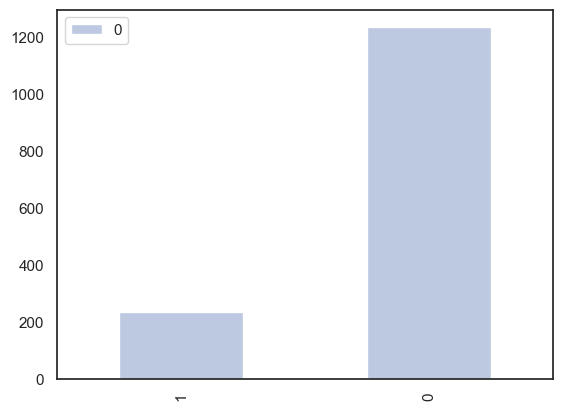

In [8]:
state_counts = Counter(attrition_features_ohe['Attrition'])
df_state = pd.DataFrame.from_dict(state_counts, orient='index')
df_state.plot(kind='bar', color='#bdc9e1')

num=(df_state[0]/df_state[0].sum())**2

print("Would Recommend:{}".format(df_state))

print("Proportion Chance Criterion: {:0.2f}%".format(100*num.sum()))
print("1.25 * Proportion Chance Criterion: {:0.2f}%".format(1.25*100*num.sum()))

# Modeling

In [9]:
y = attrition_features_ohe.Attrition
X = attrition_features_ohe.drop(["Attrition"],axis = 1)
columns = X.columns.tolist()
columns

['EnvironmentSatisfaction',
 'Gender',
 'JobLevel',
 'JobSatisfaction',
 'MonthlyIncome',
 'OverTime',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'BusinessTravel_1',
 'BusinessTravel_2',
 'BusinessTravel_3',
 'Age_Profile_1',
 'Age_Profile_2',
 'Age_Profile_3',
 'Age_Profile_4']

In [10]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, random_state=42, test_size=0.30)

In [11]:
X_train_df = pd.DataFrame(X_train, columns = columns)
X_train_df["target"] = y_train

# Logistic Regression **

In [12]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, random_state=42, test_size=0.30) 

In [13]:
lr = LogisticRegression(random_state=42)  
start_lr = time.time()
lr.fit(X_train, y_train)
end_lr = time.time()
runtime_lr = end_lr - start_lr

basescore_train_lr = lr.score(X_train, y_train)
basescore_test_lr = lr.score(X_test, y_test)

print('Train Accuracy', basescore_train_lr) 
print('Test Accuracy', basescore_test_lr)   
print('Runtime:', runtime_lr)

Train Accuracy 0.8493683187560739
Test Accuracy 0.873015873015873
Runtime: 0.014660120010375977


In [14]:
df_training_lr = pd.DataFrame()
df_test_lr = pd.DataFrame()
seedN_list_lr = range(1, 10, 1)

# hypertune random state
for seedN in tqdm(seedN_list_lr):
    X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                        test_size=0.30, random_state=seedN)

    training_accuracy_lr = []
    test_accuracy_lr = []
    alpha_run = [1e-8, 1e-5, 1e-3, 0.1, 0.2, 0.4, 0.75, 1] 

    #hypertune alpha values
    for alpha in tqdm(alpha_run):   
        lr = LogisticRegression(C=alpha, max_iter=100000)  
        lr.fit(X_train, y_train)

        training_accuracy_lr.append(lr.score(X_train, y_train)) 
        test_accuracy_lr.append(lr.score(X_test, y_test))   
    
    df_training_lr[seedN]=training_accuracy_lr
    df_test_lr[seedN] = test_accuracy_lr

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [15]:
df_test_lr

,1,2,3,4,5,6,7,8,9
0,0.825397,0.839002,0.829932,0.836735,0.827664,0.845805,0.841270,0.841270,0.829932
1,0.825397,0.839002,0.829932,0.836735,0.827664,0.845805,0.841270,0.841270,0.829932
2,0.825397,0.839002,0.829932,0.836735,0.827664,0.845805,0.841270,0.841270,0.829932
3,0.827664,0.843537,0.839002,0.848073,0.839002,0.850340,0.845805,0.850340,0.834467
4,0.829932,0.843537,0.841270,0.848073,0.843537,0.854875,0.857143,0.845805,0.839002
5,0.839002,0.852608,0.843537,0.857143,0.834467,0.857143,0.848073,0.845805,0.839002
6,0.843537,0.848073,0.843537,0.859410,0.832200,0.859410,0.848073,0.852608,0.839002
7,0.839002,0.848073,0.839002,0.861678,0.841270,0.854875,0.843537,0.852608,0.843537


In [16]:
df_accuracy_lr = pd.DataFrame({
    'C': alpha_run,
    'training_accuracy': df_training_lr.mean(axis=1),
    'test_accuracy': df_test_lr.mean(axis=1)
})
df_accuracy_lr 

,C,training_accuracy,test_accuracy
0,1.000000e-08,0.840298,0.835223
1,1.000000e-05,0.840298,0.835223
2,1.000000e-03,0.840298,0.835223
3,1.000000e-01,0.850016,0.842026
4,2.000000e-01,0.852824,0.844797
5,4.000000e-01,0.855523,0.846309
6,7.500000e-01,0.855307,0.847317
7,1.000000e+00,0.855415,0.847065


In [17]:
df_test_lr_1 = df_accuracy_lr["test_accuracy"]
df_test_max_lr = df_test_lr_1.max()
df_test_n_lr = df_test_lr_1.idxmax() + 1
print(f'Test accuracy: {df_test_max_lr: .2%}')
print(f'C: {df_test_n_lr}')

Test accuracy:  84.73%
C: 7


In [18]:
best_alpha = alpha_run[np.argmax(np.mean(df_test_lr.values, axis=1))]
best_random_state_lr = seedN_list_lr[np.argmax(np.mean(df_test_lr.values, axis=0))]
print("Best combination - alpha: {}, random_state: {}".format(best_alpha, best_random_state_lr))

Best combination - alpha: 0.75, random_state: 6


Test set accuracy: 0.84


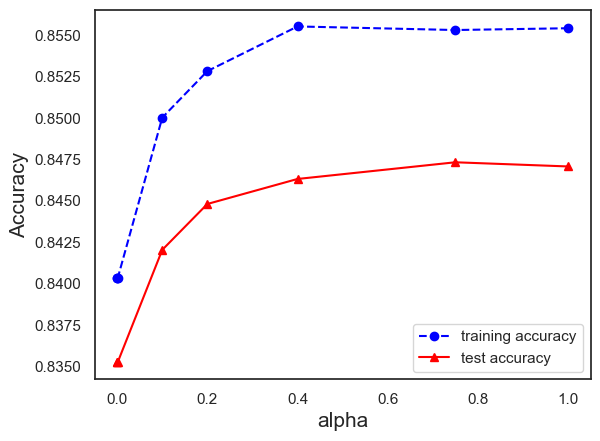

In [19]:
plt.plot(alpha_run, df_training_lr.mean(axis=1), label="training accuracy", color='blue', marker='o', linestyle='dashed')
plt.plot(alpha_run, df_test_lr.mean(axis=1), label="test accuracy",color='red', marker='^', linestyle='-')
plt.ylabel("Accuracy", fontsize=15)
plt.xlabel("alpha",fontsize=15)
plt.legend()
print("Test set accuracy: {:.2f}".format(lr.score(X_test, y_test)))

In [20]:
(X_train, X_test, y_train, y_test) = train_test_split(X, 
                                                      y, 
                                                      random_state=6, 
                                                      test_size=0.30) 
lr_1 = LogisticRegression(C=0.75, max_iter=100000, random_state=6)  
start_lr_1 = time.time()
lr_1.fit(X_train, y_train)
end_lr_1 = time.time()
runtime_lr_1 = end_lr_1 - start_lr_1

bestscore_train_lr = lr_1.score(X_train, y_train)
bestscore_test_lr = lr_1.score(X_test, y_test)

print('Train Accuracy', bestscore_train_lr) 
print('Test Accuracy', bestscore_test_lr)   
print('Runtime:', runtime_lr_1)

Train Accuracy 0.8454810495626822
Test Accuracy 0.8594104308390023
Runtime: 0.02545905113220215


In [21]:
###### SAVING ACCURACY 

In [22]:
df_accuracy_lr.to_csv('contents/modelling/ohe_data/df_accuracy_lr.csv', index=False)

In [23]:
df_training_lr.to_csv('contents/modelling/ohe_data/df_training_lr.csv', index=False)

In [24]:
df_test_lr.to_csv('contents/modelling/ohe_data/df_test_lr.csv', index=False)

# DECISION TREES

In [25]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, random_state=42, test_size=0.30) 

In [26]:
dt = DecisionTreeClassifier(random_state=42)
start_dt = time.time()
dt.fit(X_train, y_train)
end_dt = time.time()
runtime_dt = end_dt - start_dt

basescore_train_dt = dt.score(X_train, y_train)
basescore_test_dt = dt.score(X_test, y_test)

print("Accuracy on training set: %f" %basescore_train_dt)
print("Accuracy on test set: %f" %basescore_test_dt)
print('Runtime:', runtime_dt)

Accuracy on training set: 1.000000
Accuracy on test set: 0.802721
Runtime: 0.0033180713653564453


In [27]:
df_training_dt = pd.DataFrame()
df_test_dt = pd.DataFrame()
seedN_list_dt = range(1, 10, 1)

# hypertune random state
for seedN in tqdm(seedN_list_dt):
    X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                        test_size=0.30, random_state=seedN)

    training_accuracy_dt = []
    test_accuracy_dt = []
    maxdepth_settings = range(1, 11) 

    # hypertune max_depth
    for depth in tqdm(maxdepth_settings):   
        tree = DecisionTreeClassifier(max_depth=depth)
        tree.fit(X_train, y_train)

        training_accuracy_dt.append(tree.score(X_train, y_train)) 
        test_accuracy_dt.append(tree.score(X_test, y_test))   
    
    df_training_dt[seedN]=training_accuracy_dt
    df_test_dt[seedN] = test_accuracy_dt

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [28]:
df_test_dt

,1,2,3,4,5,6,7,8,9
0,0.825397,0.839002,0.829932,0.836735,0.827664,0.845805,0.841270,0.841270,0.829932
1,0.834467,0.852608,0.834467,0.841270,0.829932,0.848073,0.827664,0.852608,0.829932
2,0.829932,0.845805,0.834467,0.848073,0.827664,0.857143,0.829932,0.852608,0.848073
3,0.825397,0.841270,0.839002,0.848073,0.825397,0.863946,0.832200,0.843537,0.834467
4,0.825397,0.832200,0.825397,0.843537,0.845805,0.841270,0.836735,0.845805,0.820862
5,0.814059,0.832200,0.823129,0.839002,0.825397,0.852608,0.834467,0.839002,0.834467
6,0.818594,0.834467,0.804989,0.845805,0.814059,0.852608,0.839002,0.816327,0.818594
7,0.802721,0.818594,0.809524,0.807256,0.814059,0.832200,0.825397,0.814059,0.823129
8,0.800454,0.811791,0.800454,0.800454,0.809524,0.829932,0.804989,0.800454,0.820862
9,0.793651,0.811791,0.791383,0.798186,0.798186,0.820862,0.802721,0.807256,0.802721


In [29]:
df_accuracy_dt = pd.DataFrame({
    'max_depth': maxdepth_settings,
    'training_accuracy': df_training_dt.mean(axis=1),
    'test_accuracy': df_test_dt.mean(axis=1)
})
df_accuracy_dt 

,max_depth,training_accuracy,test_accuracy
0,1,0.840298,0.835223
1,2,0.853040,0.839002
2,3,0.860598,0.841522
3,4,0.871396,0.839254
4,5,0.884786,0.835223
5,6,0.899363,0.832703
6,7,0.916208,0.827160
7,8,0.933161,0.816327
8,9,0.949250,0.808768
9,10,0.962099,0.802973


In [30]:
df_test_dt_1 = df_accuracy_dt["test_accuracy"]
df_test_max_dt = df_test_dt_1.max()
df_test_n_dt = df_test_dt_1.idxmax() + 1
print(f'Test accuracy: {df_test_max_dt: .2%}')
print(f'max_depth: {df_test_n_dt}')

Test accuracy:  84.15%
max_depth: 3


In [31]:
best_max_depth= maxdepth_settings[np.argmax(np.mean(df_test_dt.values, axis=1))]
best_random_state_dt = seedN_list_dt[np.argmax(np.mean(df_test_dt.values, axis=0))]
print("Best combination - max_depth: {}, random_state: {}".format(best_max_depth, best_random_state_dt))

Best combination - max_depth: 3, random_state: 6


Highest Average Test Set Achieved = 0.841522
Best max_depth Parameters = 3


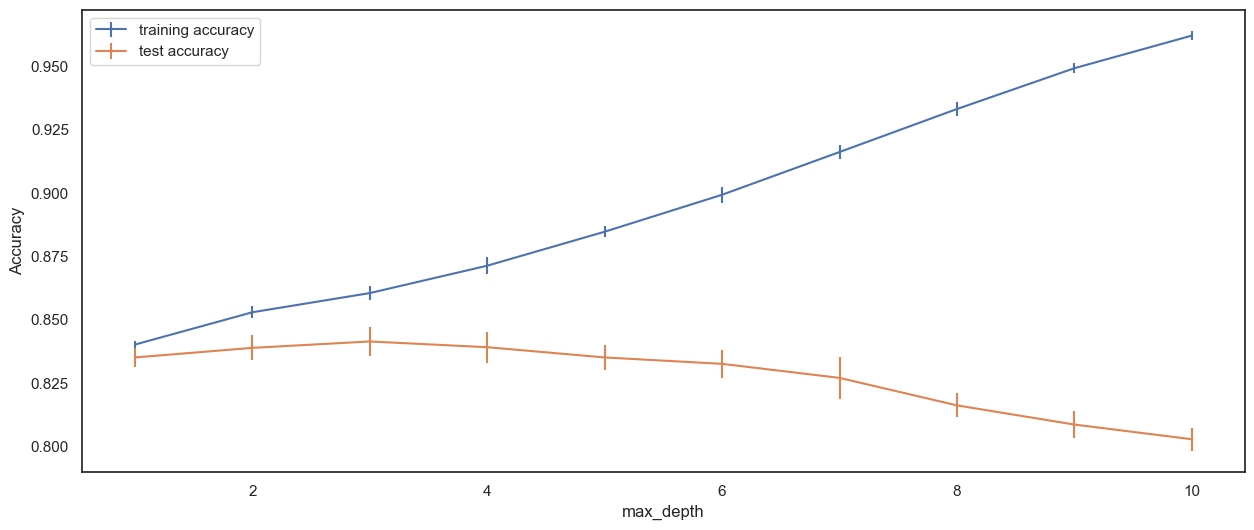

In [32]:
fig = plt.figure(figsize=(15, 6))
plt.errorbar(maxdepth_settings, df_training_dt.mean(axis=1),
             yerr=df_training_dt.std(axis=1)/2, label="training accuracy")
plt.errorbar(maxdepth_settings, df_test_dt.mean(axis=1),
             yerr=df_test_dt.std(axis=1)/2, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("max_depth")
plt.legend()
bestdepth=np.argmax(df_test_dt.mean(axis=1))+1
print("Highest Average Test Set Achieved = %f" % np.amax(df_test_dt.mean(axis=1)))
print("Best max_depth Parameters = %d" %bestdepth )

In [33]:
(X_train, X_test, y_train, y_test) = train_test_split(X, 
                                                      y,
                                                      random_state=6,
                                                      test_size=0.30) 

dt_1 = DecisionTreeClassifier(max_depth=3, random_state=6)
start_dt_1 = time.time()
dt_1.fit(X_train, y_train)
end_dt_1 = time.time()
runtime_dt_1 = end_dt_1 - start_dt_1

bestscore_train_dt = dt_1.score(X_train, y_train)
bestscore_test_dt = dt_1.score(X_test, y_test)

print("Accuracy on training set: %f" %bestscore_train_dt)
print("Accuracy on test set: %f" %bestscore_test_dt)
print('Runtime:', runtime_dt_1)

Accuracy on training set: 0.850340
Accuracy on test set: 0.857143
Runtime: 0.0015180110931396484


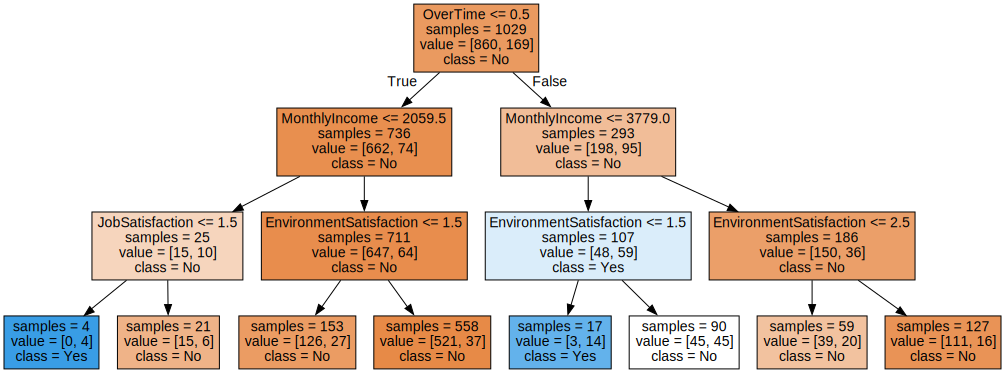

In [34]:
import graphviz
from sklearn.tree import export_graphviz

export_graphviz(dt_1, out_file="mydt.dot", class_names=["No", "Yes"],
                feature_names=X.columns, impurity=False, filled=True)


with open("mydt.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [35]:
dt_feature_importance = (pd.DataFrame({'features': X.columns, 'feature_importance':dt.feature_importances_})
                         .sort_values('feature_importance', ascending=False)[:5])
dt_feature_importance

,features,feature_importance
4,MonthlyIncome,0.326795
8,YearsAtCompany,0.144843
6,TrainingTimesLastYear,0.099077
0,EnvironmentSatisfaction,0.075444
5,OverTime,0.074690


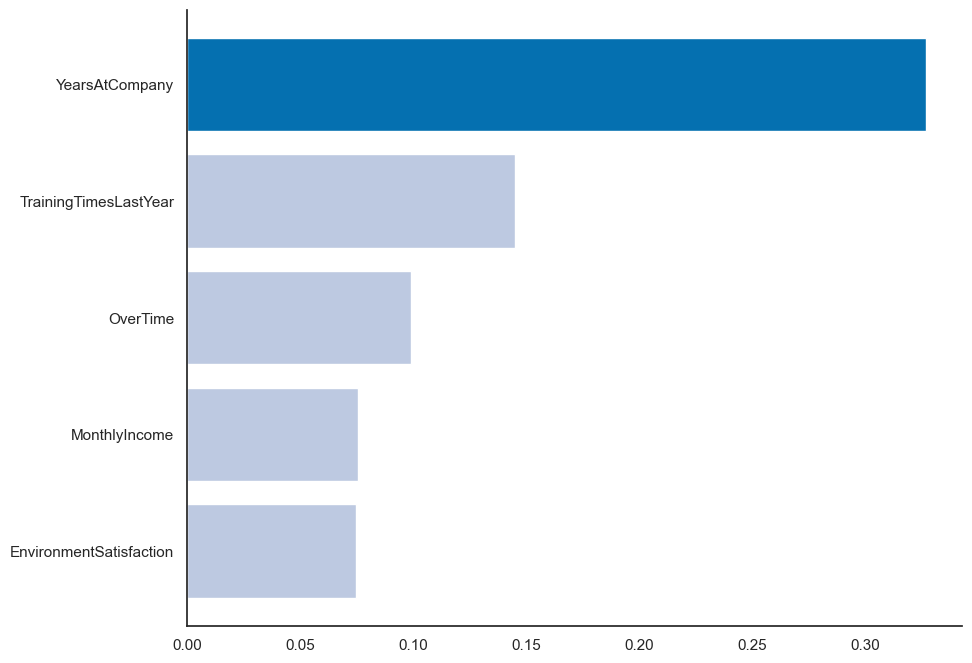

In [36]:
color = ['#bdc9e1'] * len(dt_feature_importance)
color[-1] = '#0570b0' 
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(dt_feature_importance.features.sort_values(), dt_feature_importance.feature_importance.sort_values(), color=color)
for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
plt.show()

In [37]:
df_accuracy_dt.to_csv("contents/modelling/ohe_data/df_accuracy_dt.csv", index=False)

In [38]:
df_training_dt.to_csv("contents/modelling/ohe_data/df_training_dt.csv", index=False)

In [39]:
df_test_dt.to_csv("contents/modelling/ohe_data/df_test_dt.csv", index=False)

# Random Forest

In [40]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, random_state=42, test_size=0.30) 

In [41]:
rf = RandomForestClassifier(random_state=42)
start_rf = time.time()
rf.fit(X_train, y_train)
end_rf = time.time()
runtime_rf = end_rf-start_rf

basescore_train_rf = rf.score(X_train, y_train)
basescore_test_rf = rf.score(X_test, y_test)

print("Accuracy on training set: %f" %basescore_train_rf)
print("Accuracy on test set: %f" %basescore_test_rf)
print('Runtime:', runtime_rf)

Accuracy on training set: 1.000000
Accuracy on test set: 0.863946
Runtime: 0.080902099609375


In [42]:
df_training_rf = pd.DataFrame()
df_test_rf = pd.DataFrame()
seedN_list_rf = range(1, 10, 1)

for seedN in tqdm(seedN_list_rf):
    X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                        test_size=0.30, random_state=seedN)

    training_accuracy_rf = []
    test_accuracy_rf = []
    n_estimators = range(1, 11) 
    
    for n in tqdm(n_estimators):   
        rf = RandomForestClassifier(n_estimators=n)  
        rf.fit(X_train, y_train)

        training_accuracy_rf.append(rf.score(X_train, y_train)) 
        test_accuracy_rf.append(rf.score(X_test, y_test))   
    
    df_training_rf[seedN]=training_accuracy_rf
    df_test_rf[seedN] = test_accuracy_rf

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [43]:
df_test_rf

,1,2,3,4,5,6,7,8,9
0,0.809524,0.784580,0.789116,0.757370,0.727891,0.768707,0.766440,0.734694,0.746032
1,0.807256,0.845805,0.818594,0.834467,0.818594,0.836735,0.843537,0.834467,0.823129
2,0.786848,0.791383,0.816327,0.827664,0.786848,0.820862,0.811791,0.811791,0.829932
3,0.814059,0.836735,0.823129,0.839002,0.829932,0.852608,0.857143,0.845805,0.829932
4,0.807256,0.829932,0.798186,0.829932,0.814059,0.818594,0.829932,0.832200,0.820862
5,0.845805,0.839002,0.827664,0.823129,0.818594,0.857143,0.843537,0.836735,0.829932
6,0.829932,0.823129,0.802721,0.811791,0.827664,0.866213,0.811791,0.829932,0.829932
7,0.841270,0.848073,0.848073,0.823129,0.841270,0.845805,0.834467,0.827664,0.850340
8,0.843537,0.832200,0.839002,0.854875,0.829932,0.845805,0.823129,0.845805,0.834467
9,0.848073,0.839002,0.834467,0.843537,0.825397,0.852608,0.832200,0.854875,0.836735


In [44]:
df_accuracy_rf = pd.DataFrame({
    'n_estimators': n_estimators,
    'training_accuracy': df_training_rf.mean(axis=1),
    'test_accuracy': df_test_rf.mean(axis=1)
})
df_accuracy_rf

,n_estimators,training_accuracy,test_accuracy
0,1,0.922039,0.764928
1,2,0.930245,0.829176
2,3,0.959184,0.809272
3,4,0.954217,0.836483
4,5,0.976244,0.820106
5,6,0.968038,0.835727
6,7,0.985747,0.825901
7,8,0.976676,0.840010
8,9,0.987042,0.838750
9,10,0.983587,0.840766


In [45]:
df_test_rf_1 = df_accuracy_rf["test_accuracy"]
df_test_max_rf = df_test_rf_1.max()
df_test_n_rf = df_test_rf_1.idxmax() + 1
print(f'Test accuracy: {df_test_max_rf: .2%}')
print(f'n_estimators: {df_test_n_rf}')

Test accuracy:  84.08%
n_estimators: 10


In [46]:
best_n_estimators= n_estimators[np.argmax(np.mean(df_test_rf.values, axis=1))]
best_random_state_rf = seedN_list_rf[np.argmax(np.mean(df_test_rf.values, axis=0))]
print("Best combination - n_estimator: {}, random_state: {}".format(best_n_estimators, best_random_state_rf))

Best combination - n_estimator: 10, random_state: 6


Highest Average Test Set Achieved = 0.840766
Best n_estimators Parameters = 10


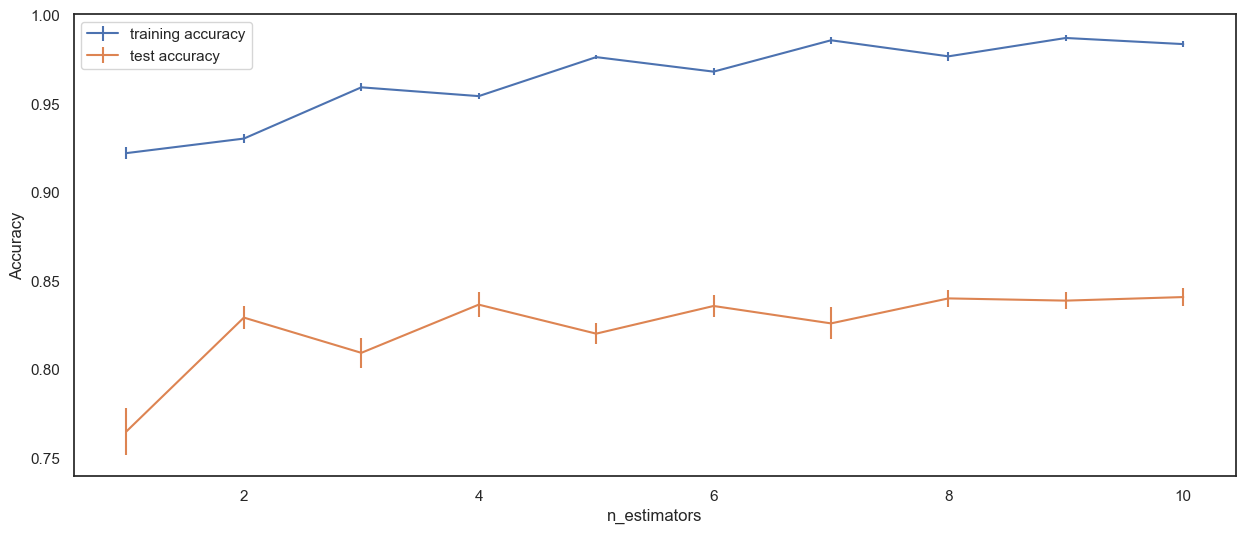

In [47]:
fig = plt.figure(figsize=(15, 6))
plt.errorbar(n_estimators, df_training_rf.mean(axis=1),
             yerr=df_training_rf.std(axis=1)/2, label="training accuracy")
plt.errorbar(n_estimators, df_test_rf.mean(axis=1),
             yerr=df_test_rf.std(axis=1)/2, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_estimators")
plt.legend()
bestestimator=np.argmax(df_test_rf.mean(axis=1))+1
print("Highest Average Test Set Achieved = %f" % np.amax(df_test_rf.mean(axis=1)))
print("Best n_estimators Parameters = %d" %bestestimator )

In [48]:
(X_train, X_test, y_train, y_test) = train_test_split(X, 
                                                      y, 
                                                      random_state=6, 
                                                      test_size=0.30) 

rf_1 = RandomForestClassifier(n_estimators=6, random_state=6)
start_rf_1 = time.time()
rf_1.fit(X_train, y_train)
end_rf_1 = time.time()
runtime_rf_1 = end_rf_1-start_rf_1

bestscore_train_rf = rf_1.score(X_train, y_train)
bestscore_test_rf = rf_1.score(X_test, y_test)

print("Accuracy on training set: %f" %bestscore_train_rf)
print("Accuracy on test set: %f" %bestscore_test_rf)
print('Runtime:', runtime_rf_1)

Accuracy on training set: 0.969874
Accuracy on test set: 0.854875
Runtime: 0.0058269500732421875


In [49]:
df_accuracy_rf.to_csv("contents/modelling/ohe_data/df_accuracy_rf.csv", index=False)

In [50]:
df_training_rf.to_csv("contents/modelling/ohe_data/df_training_rf.csv", index=False)

In [51]:
df_test_rf.to_csv("contents/modelling/ohe_data/df_test_rf.csv", index=False)

# Gradient Boosting

In [52]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, random_state=42, test_size=0.30) 

In [53]:
gbm = GradientBoostingClassifier(random_state=42)
start_gbm = time.time()
gbm.fit(X_train, y_train)
end_gbm = time.time()
runtime_gbm = end_gbm - start_gbm

basescore_train_gbm = gbm.score(X_train, y_train)
basescore_test_gbm = gbm.score(X_test, y_test)

print("Accuracy on training set: %f" %basescore_train_gbm)
print("Accuracy on test set: %f" %basescore_test_gbm)
print('Runtime:', runtime_gbm)

Accuracy on training set: 0.912536
Accuracy on test set: 0.866213
Runtime: 0.07600688934326172


In [54]:
df_training_gbm = pd.DataFrame()
df_test_gbm = pd.DataFrame()
seedN_list_gbm = range(1, 10, 1)

for seedN in tqdm(seedN_list_gbm):
    X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                        test_size=0.30, random_state=seedN)

    training_accuracy_gbm = []
    test_accuracy_gbm = []
    learning_rate = [0.1, 0.01, 0.001, 0.0001, 0.5, 0.05, 0.005] 

    for n in tqdm(learning_rate):   
        gbm = GradientBoostingClassifier(learning_rate=n)  
        gbm.fit(X_train, y_train)

        training_accuracy_gbm.append(gbm.score(X_train, y_train)) 
        test_accuracy_gbm.append(gbm.score(X_test, y_test))   
    
    df_training_gbm[seedN]=training_accuracy_gbm
    df_test_gbm[seedN] = test_accuracy_gbm

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [55]:
df_test_gbm

,1,2,3,4,5,6,7,8,9
0,0.839002,0.857143,0.832200,0.854875,0.863946,0.859410,0.839002,0.843537,0.845805
1,0.829932,0.852608,0.832200,0.850340,0.832200,0.857143,0.839002,0.845805,0.841270
2,0.825397,0.839002,0.829932,0.836735,0.827664,0.845805,0.841270,0.841270,0.829932
3,0.825397,0.839002,0.829932,0.836735,0.827664,0.845805,0.841270,0.841270,0.829932
4,0.793651,0.827664,0.829932,0.825397,0.825397,0.836735,0.823129,0.804989,0.850340
5,0.834467,0.857143,0.845805,0.859410,0.854875,0.868481,0.848073,0.859410,0.841270
6,0.825397,0.839002,0.829932,0.836735,0.827664,0.845805,0.841270,0.841270,0.829932


In [56]:
df_accuracy_gbm = pd.DataFrame({
    'learning_rate': learning_rate,
    'training_accuracy': df_training_gbm.mean(axis=1),
    'test_accuracy': df_test_gbm.mean(axis=1)
})
df_accuracy_gbm

,learning_rate,training_accuracy,test_accuracy
0,0.1000,0.916856,0.848325
1,0.0100,0.854875,0.842278
2,0.0010,0.840298,0.835223
3,0.0001,0.840298,0.835223
4,0.5000,0.997624,0.824137
5,0.0500,0.897095,0.852104
6,0.0050,0.840298,0.835223


In [57]:
df_test_gbm_1 = df_accuracy_gbm["test_accuracy"]
df_test_max_gbm = df_test_gbm_1.max()
df_test_n_gbm = df_test_gbm_1.idxmax() + 1
print(f'Test accuracy: {df_test_max_gbm: .2%}')
print(f'learning_rate: {df_test_n_gbm}')

Test accuracy:  85.21%
learning_rate: 6


In [58]:
best_learning_rate = learning_rate[np.argmax(np.mean(df_test_gbm.values, axis=1))]
best_random_state_gbm = seedN_list_gbm[np.argmax(np.mean(df_test_gbm.values, axis=0))]
print("Best combination - learning rate: {}, random_state: {}".format(best_learning_rate, best_random_state_gbm))

Best combination - learning rate: 0.05, random_state: 6


Highest Average Test Set Achieved = 0.852104
Best lr Parameters = 6


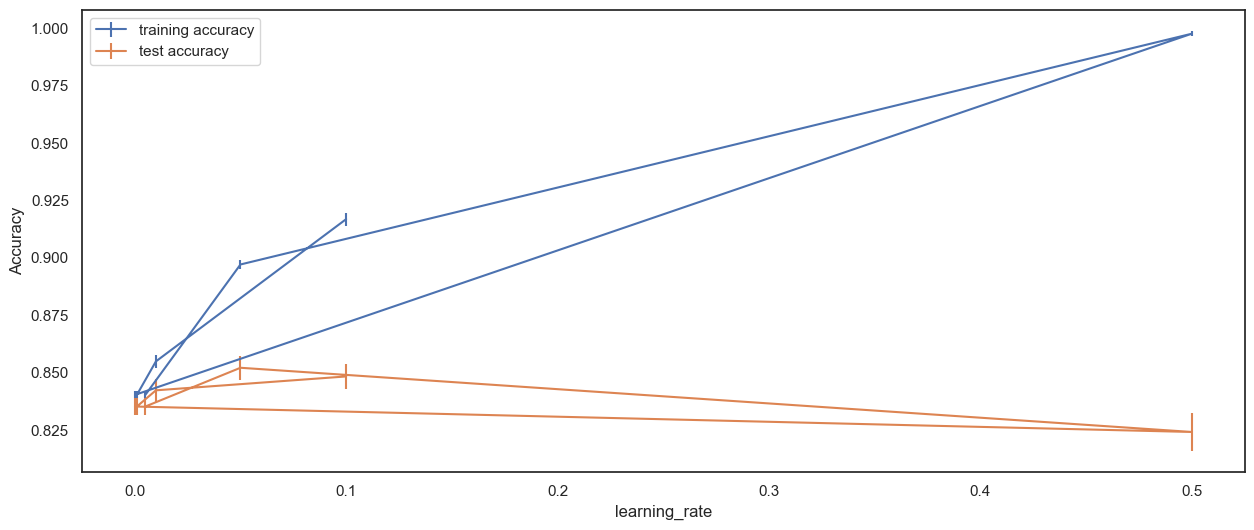

In [59]:
fig = plt.figure(figsize=(15, 6))
plt.errorbar(learning_rate, df_training_gbm.mean(axis=1),
             yerr=df_training_gbm.std(axis=1)/2, label="training accuracy")
plt.errorbar(learning_rate, df_test_gbm.mean(axis=1),
             yerr=df_test_gbm.std(axis=1)/2, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("learning_rate")
plt.legend()
besteslr=np.argmax(df_test_gbm.mean(axis=1))+1
print("Highest Average Test Set Achieved = %f" % np.amax(df_test_gbm.mean(axis=1)))
print("Best lr Parameters = %d" %besteslr )

In [60]:
(X_train, X_test, y_train, y_test) = train_test_split(X, 
                                                      y, 
                                                      random_state=6, 
                                                      test_size=0.30) 

gbm_1 = GradientBoostingClassifier(learning_rate=0.05, random_state=6)
start_gbm_1 = time.time()
gbm_1.fit(X_train, y_train)
end_gbm_1 = time.time()
runtime_gbm_1 = end_gbm_1 - start_gbm_1

bestscore_train_gbm = gbm_1.score(X_train, y_train)
bestscore_test_gbm = gbm_1.score(X_test, y_test)

print("Accuracy on training set: %f" %bestscore_train_gbm)
print("Accuracy on test set: %f" %bestscore_test_gbm)
print('Runtime:', runtime_gbm_1)

Accuracy on training set: 0.890185
Accuracy on test set: 0.868481
Runtime: 0.07547402381896973


In [61]:
df_accuracy_gbm.to_csv("contents/modelling/ohe_data/df_accuracy_gbm.csv", index=False)

In [62]:
df_training_gbm.to_csv("contents/modelling/ohe_data/df_training_gbm.csv", index=False)

In [63]:
df_test_gbm.to_csv("contents/modelling/ohe_data/df_test_gbm.csv", index=False)

# KNN

In [64]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, random_state=42, test_size=0.30) 

In [65]:
knn = KNeighborsClassifier() 
start_knn = time.time()
knn.fit(X_train, y_train)
end_knn = time.time()
runtime_knn = end_knn - start_knn

basescore_train_knn = knn.score(X_train, y_train)
basescore_test_knn = knn.score(X_test, y_test)

print('Train Accuracy', basescore_train_knn)
print('Test Accuracy', basescore_test_knn)   
print('Runtime:', runtime_knn)

Train Accuracy 0.8493683187560739
Test Accuracy 0.8231292517006803
Runtime: 0.001168966293334961


In [66]:
df_training_knn = pd.DataFrame()
df_test_knn = pd.DataFrame()
seedN_list_knn = range(1, 10, 1)

for seedN in tqdm(seedN_list_knn):
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.30, random_state=seedN)

    training_accuracy_knn = []
    test_accuracy_knn = []
    n_neighbors = [3, 5, 7] # different values for n_neighbors

    for k in tqdm(n_neighbors):   
        knn = KNeighborsClassifier(n_neighbors=k)  # build the model
        knn.fit(X_train, y_train)

        training_accuracy_knn.append(knn.score(X_train, y_train)) # record training set accuracy
        test_accuracy_knn.append(knn.score(X_test, y_test))   # record generalization accuracy
    
    df_training_knn[seedN]=training_accuracy_knn
    df_test_knn[seedN] = test_accuracy_knn

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test set accuracy: 0.82


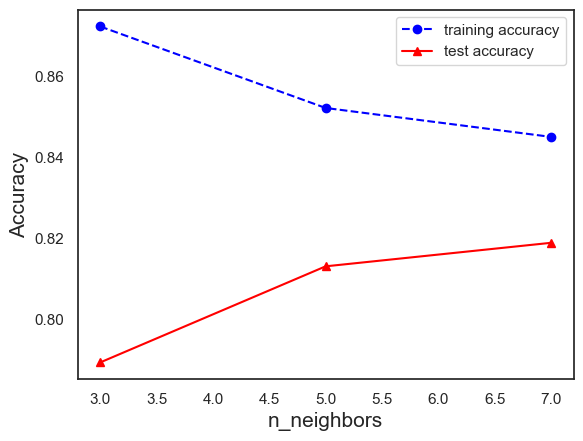

In [67]:
plt.plot(n_neighbors, df_training_knn.mean(axis=1), label="training accuracy", color='blue', marker='o', linestyle='dashed')
plt.plot(n_neighbors, df_test_knn.mean(axis=1), label="test accuracy",color='red', marker='^', linestyle='-')
plt.ylabel("Accuracy", fontsize=15)
plt.xlabel("n_neighbors",fontsize=15)
plt.legend()
print("Test set accuracy: {:.2f}".format(knn.score(X_test, y_test)))

In [68]:
df_accuracy_knn = pd.DataFrame({
    'n_neighbors': n_neighbors,
    'training_accuracy': df_training_knn.mean(axis=1),
    'test_accuracy': df_test_knn.mean(axis=1)
})
df_accuracy_knn

,n_neighbors,training_accuracy,test_accuracy
0,3,0.872152,0.789368
1,5,0.852068,0.813051
2,7,0.844941,0.818846


In [69]:
df_test_knn_1 = df_accuracy_knn["test_accuracy"]
df_test_max_knn = df_test_knn_1.max()
df_test_n_knn = df_test_knn_1.idxmax() + 1
print(f'Test accuracy: {df_test_max_knn: .2%}')
print(f'n_neighbor: {df_test_n_knn}')

Test accuracy:  81.88%
n_neighbor: 3


In [70]:
df_test_knn

,1,2,3,4,5,6,7,8,9
0,0.775510,0.816327,0.773243,0.798186,0.773243,0.809524,0.791383,0.804989,0.761905
1,0.809524,0.825397,0.782313,0.818594,0.814059,0.829932,0.811791,0.832200,0.793651
2,0.804989,0.829932,0.795918,0.811791,0.814059,0.839002,0.825397,0.832200,0.816327


In [71]:
best_neighbor = n_neighbors[np.argmax(np.mean(df_test_knn.values, axis=1))]
best_random_state_knn = seedN_list_knn[np.argmax(np.mean(df_test_knn.values, axis=0))]
print("Best combination - neighbor: {}, random_state: {}".format(best_neighbor, best_random_state_knn))

Best combination - neighbor: 7, random_state: 6


In [72]:
(X_train, X_test, y_train, y_test) = train_test_split(X, 
                                                      y, 
                                                      random_state=6, 
                                                      test_size=0.30) 

knn_1 = KNeighborsClassifier(n_neighbors=7)  
start_knn_1 = time.time()
knn_1.fit(X_train, y_train)
end_knn_1 = time.time()
runtime_knn_1 = end_knn_1 - start_knn_1

bestscore_train_knn = knn_1.score(X_train, y_train)
bestscore_test_knn = knn_1.score(X_test, y_test)

print('Train Accuracy', bestscore_train_knn) 
print('Test Accuracy', bestscore_test_knn)   
print('Runtime:', runtime_knn_1)

Train Accuracy 0.8396501457725948
Test Accuracy 0.8390022675736961
Runtime: 0.0007228851318359375


In [73]:
df_accuracy_knn.to_csv("contents/modelling/ohe_data/df_accuracy_knn.csv", index=False)

In [74]:
df_training_knn.to_csv("contents/modelling/ohe_data/df_training_knn.csv", index=False)

In [75]:
df_test_knn.to_csv("contents/modelling/ohe_data/df_test_knn.csv", index=False)

In [76]:
# create empty dataframe
results_df = pd.DataFrame(columns=['model', 'baseline_train_accuracy', 'baseline_test_accuracy', 'baseline_runtime', 'best_train_accuracy', 'best_test_accuracy', 'best_runtime'])

results_df = results_df.append({'model': 'logistic regression', 
                                'baseline_train_accuracy': basescore_train_lr, 
                                'baseline_test_accuracy': basescore_test_lr, 
                                'baseline_runtime': runtime_lr,
                                'best_train_accuracy': bestscore_train_lr, 
                                'best_test_accuracy': bestscore_test_lr,
                                'best_runtime': runtime_lr_1}, ignore_index=True)

results_df = results_df.append({'model': 'random forest', 
                                'baseline_train_accuracy': basescore_train_rf, 
                                'baseline_test_accuracy': basescore_test_rf, 
                                'baseline_runtime': runtime_rf,
                                'best_train_accuracy': bestscore_train_rf, 
                                'best_test_accuracy': bestscore_test_rf,
                                'best_runtime': runtime_rf}, ignore_index=True)

results_df = results_df.append({'model': 'decision trees', 
                                'baseline_train_accuracy': basescore_train_dt, 
                                'baseline_test_accuracy': basescore_test_dt, 
                                'baseline_runtime': runtime_dt,
                                'best_train_accuracy': bestscore_train_dt, 
                                'best_test_accuracy': bestscore_test_dt,
                                'best_runtime': runtime_dt_1}, ignore_index=True)

results_df = results_df.append({'model': 'gradient boosting', 
                                'baseline_train_accuracy': basescore_train_gbm, 
                                'baseline_test_accuracy': basescore_test_gbm, 
                                'baseline_runtime': runtime_gbm,
                                'best_train_accuracy': bestscore_train_gbm, 
                                'best_test_accuracy': bestscore_test_gbm,
                                'best_runtime': runtime_gbm_1}, ignore_index=True)

results_df = results_df.append({'model': 'knn', 
                                'baseline_train_accuracy': basescore_train_knn, 
                                'baseline_test_accuracy': basescore_test_knn, 
                                'baseline_runtime': runtime_knn,
                                'best_train_accuracy': bestscore_train_knn, 
                                'best_test_accuracy': bestscore_test_knn,
                                'best_runtime': runtime_knn_1}, ignore_index=True)

results_df

,model,baseline_train_accuracy,baseline_test_accuracy,baseline_runtime,best_train_accuracy,best_test_accuracy,best_runtime
0,logistic regression,0.849368,0.873016,0.014660,0.845481,0.859410,0.025459
1,random forest,1.000000,0.863946,0.080902,0.969874,0.854875,0.080902
2,decision trees,1.000000,0.802721,0.003318,0.850340,0.857143,0.001518
3,gradient boosting,0.912536,0.866213,0.076007,0.890185,0.868481,0.075474
4,knn,0.849368,0.823129,0.001169,0.839650,0.839002,0.000723


In [77]:
results_df.to_csv("contents/modelling/ohe_data/results_df.csv")

In [78]:
sorted_results_df = results_df.sort_values(by='best_test_accuracy', ascending=False)
sorted_results_df

,model,baseline_train_accuracy,baseline_test_accuracy,baseline_runtime,best_train_accuracy,best_test_accuracy,best_runtime
3,gradient boosting,0.912536,0.866213,0.076007,0.890185,0.868481,0.075474
0,logistic regression,0.849368,0.873016,0.014660,0.845481,0.859410,0.025459
2,decision trees,1.000000,0.802721,0.003318,0.850340,0.857143,0.001518
1,random forest,1.000000,0.863946,0.080902,0.969874,0.854875,0.080902
4,knn,0.849368,0.823129,0.001169,0.839650,0.839002,0.000723


In [79]:
sorted_results_df_1 = results_df.sort_values(by='best_runtime', ascending=False)
sorted_results_df_1

,model,baseline_train_accuracy,baseline_test_accuracy,baseline_runtime,best_train_accuracy,best_test_accuracy,best_runtime
1,random forest,1.000000,0.863946,0.080902,0.969874,0.854875,0.080902
3,gradient boosting,0.912536,0.866213,0.076007,0.890185,0.868481,0.075474
0,logistic regression,0.849368,0.873016,0.014660,0.845481,0.859410,0.025459
2,decision trees,1.000000,0.802721,0.003318,0.850340,0.857143,0.001518
4,knn,0.849368,0.823129,0.001169,0.839650,0.839002,0.000723


In [80]:
results_df.sort_values(by='best_test_accuracy', ascending=False)

,model,baseline_train_accuracy,baseline_test_accuracy,baseline_runtime,best_train_accuracy,best_test_accuracy,best_runtime
3,gradient boosting,0.912536,0.866213,0.076007,0.890185,0.868481,0.075474
0,logistic regression,0.849368,0.873016,0.014660,0.845481,0.859410,0.025459
2,decision trees,1.000000,0.802721,0.003318,0.850340,0.857143,0.001518
1,random forest,1.000000,0.863946,0.080902,0.969874,0.854875,0.080902
4,knn,0.849368,0.823129,0.001169,0.839650,0.839002,0.000723


In [81]:
results_df.sort_values(by='baseline_train_accuracy', ascending=False)

,model,baseline_train_accuracy,baseline_test_accuracy,baseline_runtime,best_train_accuracy,best_test_accuracy,best_runtime
1,random forest,1.000000,0.863946,0.080902,0.969874,0.854875,0.080902
2,decision trees,1.000000,0.802721,0.003318,0.850340,0.857143,0.001518
3,gradient boosting,0.912536,0.866213,0.076007,0.890185,0.868481,0.075474
0,logistic regression,0.849368,0.873016,0.014660,0.845481,0.859410,0.025459
4,knn,0.849368,0.823129,0.001169,0.839650,0.839002,0.000723
